## Import Libraries:

In [1]:
import warnings
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import os  # For interacting with the operating system
import matplotlib.pyplot as plt  # For plotting graphs
from sklearn.model_selection import ParameterGrid  # For generating parameter grid for hyperparameter tuning
from sklearn.metrics import log_loss  # For calculating log loss metric

# Suppress specific UserWarnings from the 'openpyxl' module to prevent cluttering the output
warnings.filterwarnings("ignore", category=UserWarning, module='openpyxl')## Load the data:

## Load the data:

In [2]:
# Define the directory where your files are located
# data_dir = '.'  
data_dir = os.path.join(os.path.pardir) 

In [3]:
# List to hold the dataframes
dataframes = []

# Loop through the years and load the files
for year in range(2005, 2020):
    if year <= 2012:
        file_path = os.path.join(data_dir, f'{year}.xls')
    else:
        file_path = os.path.join(data_dir, f'{year}.xlsx')
    
    # Load the file into a dataframe
    df = pd.read_excel(file_path)
    
    # Append the dataframe to the list
    dataframes.append(df)

In [4]:
# Concatenate all the dataframes into one
betting_data = pd.concat(dataframes, ignore_index=True)## Load the data:

## Fixing Anomalies

In [5]:
def is_column_numeric(df, column_name):
    # Check if the column contains only numeric values
    return df[column_name].apply(lambda x: str(x).isnumeric()).all()

In [6]:
# Check if columns are numeric before converting
anomaly_column = ['WRank', 'LRank', 'EXW']
for column in anomaly_column:
    if is_column_numeric(betting_data, column):
        print(f"Column '{column}' is numeric.\n")
    else:
        print(f"Column '{column}' is not numeric.\n")

Column 'WRank' is not numeric.

Column 'LRank' is not numeric.

Column 'EXW' is not numeric.



In [7]:
def find_non_numeric_values(df, column_name):
    # Function to check if a value is numeric
    def is_numeric(value):
        try:
            float(value)
            return True
        except ValueError:
            return False

    # Apply the function to the column and filter non-numeric values
    non_numeric_values = df[~df[column_name].apply(is_numeric)]

    # Display the non-numeric values
    print(f"Non-numeric values in {column_name}:")
    print(non_numeric_values[[column_name]])
    print()

In [8]:
# WRank column
find_non_numeric_values(betting_data, 'WRank')

Non-numeric values in WRank:
Empty DataFrame
Columns: [WRank]
Index: []



In [9]:
# LRank column
find_non_numeric_values(betting_data, 'LRank')

Non-numeric values in LRank:
Empty DataFrame
Columns: [LRank]
Index: []



In [10]:
# EXW column
find_non_numeric_values(betting_data, 'EXW')

Non-numeric values in EXW:
        EXW
23776  2.,3



In [11]:
# Convert WRank and LRank to numeric, coercing errors
betting_data['WRank'] = pd.to_numeric(betting_data['WRank'], errors='coerce')
betting_data['LRank'] = pd.to_numeric(betting_data['LRank'], errors='coerce')

# Fill NaN values with a high number
betting_data['WRank'].fillna(100000, inplace=True)
betting_data['LRank'].fillna(100000, inplace=True)


# Correct the typo in row 38294, column 'EXW'
if betting_data.at[38294, 'EXW'] == '2.,3':
    betting_data.at[38294, 'EXW'] = '2.3'

## Preprocess Dataset:

In [12]:
# Create a new column 'higher_rank_won' to indicate if the higher-ranked player won the match
betting_data['higher_rank_won'] = (betting_data['WRank'] < betting_data['LRank']).astype(int)

# Calculate the points for the higher-ranked player: 
# If the higher-ranked player won, use their points ('WPts'); otherwise, use the opponent's points ('LPts')
betting_data['higher_rank_points'] = betting_data['higher_rank_won'] * betting_data['WPts'] + betting_data['LPts'] * (1 - betting_data['higher_rank_won'])

# Calculate the points for the lower-ranked player:
# If the higher-ranked player lost, use their points ('WPts'); otherwise, use the opponent's points ('LPts')
betting_data['lower_rank_points'] = (1 - betting_data['higher_rank_won']) * betting_data['WPts'] + betting_data['LPts'] * betting_data['higher_rank_won']

# Fill any missing values in 'higher_rank_points' with 0 to avoid issues in further calculations
betting_data['higher_rank_points'].fillna(0, inplace=True)

# Fill any missing values in 'lower_rank_points' with 0 to ensure consistency in the dataset
betting_data['lower_rank_points'].fillna(0, inplace=True)

# Filter the DataFrame to include only rows where the match status is 'Completed'
# This ensures that only fully played matches are considered in the analysis
betting_data = betting_data.loc[betting_data['Comment'] == 'Completed']

# Create a copy of the betting_data DataFrame, named 'all_matches_k', for further processing
all_matches_k = betting_data.copy()

# List of columns to drop from the dataset as they are not needed for the analysis
columns_to_drop = [
    'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets', 'Comment',
    'CBW', 'CBL', 'IWW', 'IWL', 'B365W', 'B365L', 
    'EXW', 'EXL', 'PSW', 'PSL', 'WPts', 'LPts', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL',
    'MaxW', 'MaxL', 'AvgW', 'AvgL'
]

# Drop the unnecessary columns from 'all_matches_k' to simplify the dataset for analysis
all_matches_k = all_matches_k.drop(columns=columns_to_drop)

## K-Factor Model Setup and Definitions:

In [13]:
def win_probability(E_i, E_j):
    """
    Calculate the probability of Player i winning against Player j based on their ratings.

    Parameters:
    E_i (float): The rating of Player i.
    E_j (float): The rating of Player j.

    Returns:
    float: The probability of Player i winning.
    """
    # Calculate and return the win probability using the Elo rating formula
    return 1 / (1 + 10 ** ((E_j - E_i) / 400))

In [14]:
def get_player_elo(player_name):
    """
    Retrieve the Elo rating of a player. If the player is not in the Elo dictionary,
    assign them an initial Elo rating.

    Parameters:
    player_name (str): The name of the player.

    Returns:
    float: The Elo rating of the player.
    """
    # Check if the player is in the dictionary of Elo ratings
    if player_name not in players_elo:
        # If the player is not found, assign them the initial Elo rating
        players_elo[player_name] = initial_elo
        
    # Return the player's Elo rating    
    return players_elo[player_name]

In [15]:
def set_player_elo(player_name, elo):
    """
    Set the Elo rating for a specific player.

    Parameters:
    player_name (str): The name of the player.
    elo (float): The new Elo rating to be assigned to the player.
    """
    # Assign the given Elo rating to the specified player in the players_elo dictionary
    players_elo[player_name] = elo

In [16]:
def update_elo_k(E_i, E_j, K, outcome):
    """
    Update the Elo rating for a player based on the match outcome using the Elo rating system.

    Parameters:
    E_i (float): The current Elo rating of player i.
    E_j (float): The Elo rating of the opponent, player j.
    K (float): The K-factor, which determines how much the Elo rating changes after a match.
    outcome (str): The outcome of the match for player i. Should be 'win' or 'loss'.

    Returns:
    float: The updated Elo rating of player i.
    """
    pi_j = win_probability(E_i, E_j)  # Calculate win probability for player i against player j
    if outcome == 'win':
        delta_E_i = K * (1 - pi_j)  # Elo rating change for a win
        new_E_i = E_i + delta_E_i
    elif outcome == 'loss':
        delta_E_i = K * (pi_j - 1)  # Elo rating change for a loss
        new_E_i = E_j + delta_E_i
    else:
        raise ValueError("Outcome must be 'win' or 'loss'")
    return new_E_i

In [17]:
def evaluate_model(df):
    """
    Evaluate the performance of a model by calculating log loss, accuracy, and calibration.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the actual outcomes and predicted probabilities.
                           Expected columns:
                           - 'higher_rank_won': Actual outcome (1 if higher-ranked player won, 0 otherwise).
                           - 'prob_high_ranked': Predicted probability of the higher-ranked player winning.
                           - 'match_outcome': Actual match outcome (can be used to calculate accuracy).

    Returns:
    tuple: A tuple containing:
           - logloss_value (float): The log loss of the predictions.
           - accuracy_value (float): The accuracy of the model.
           - calibration_value (float): The calibration metric for the predictions.
    """
    # Calculate log loss between the actual outcomes and predicted probabilities
    logloss_value = log_loss(df.higher_rank_won, df.prob_high_ranked)
    
    # Calculate accuracy by comparing predicted match outcome with the actual outcome
    accuracy_value = np.mean(df.match_outcome == df.higher_rank_won)
    
    # Calculate calibration by dividing the sum of predicted probabilities by the sum of actual outcomes
    calibration_value = np.sum(df.prob_high_ranked) / np.sum(df.higher_rank_won)
    
    # Return the calculated metrics
    return accuracy_value, calibration_value, logloss_value

In [18]:
def update_elo_and_probabilities_k(df, K):
    """
    Update the Elo ratings and win probabilities for each match in the dataset.

    Parameters:
    df (pandas.DataFrame): DataFrame containing match data. Expected columns:
                           - 'Winner': Name of the player who won the match.
                           - 'Loser': Name of the player who lost the match.
                           - 'higher_rank_won': Boolean indicating if the higher-ranked player won.
    K (float): The K-factor, which determines how much the Elo rating changes after a match.

    Returns:
    None: The DataFrame is modified in place with updated Elo ratings and probabilities.
    """
    for index, match in df.iterrows():
        winner_name, loser_name = match['Winner'], match['Loser']

        # Retrieve current Elo ratings
        winner_elo = get_player_elo(winner_name)
        loser_elo = get_player_elo(loser_name)
        
        # Calculate win probabilities
        df.at[index, 'prob_winner'] = win_probability(winner_elo, loser_elo)

        # Determine match outcomes based on probability and who was expected to win
        if match['higher_rank_won']:
            df.at[index, 'match_outcome'] = int(df.at[index, 'prob_winner'] > 0.5)
            df.at[index, 'prob_high_ranked'] = df.at[index, 'prob_winner']
        else:
            df.at[index, 'match_outcome'] = int((1 - df.at[index, 'prob_winner']) > 0.5)
            df.at[index, 'prob_high_ranked'] = 1 - df.at[index, 'prob_winner']

        # Update Elo ratings
        new_winner_elo = update_elo_k(winner_elo, loser_elo, K, 'win')
        new_loser_elo = update_elo_k(winner_elo, loser_elo, K, 'loss')
        set_player_elo(winner_name, new_winner_elo)
        set_player_elo(loser_name, new_loser_elo)

## Optimisation of K - value:

In [19]:
# Initialize the initial Elo rating for all players
initial_elo = 1500

results = []

# Check K values from 1 to 100
for K in range(1, 101):
    players_elo = {}
    all_matches_k_elo = all_matches_k.copy()
    update_elo_and_probabilities_k(all_matches_k_elo, K)
    all_matches_k_elo['Date'] = pd.to_datetime(all_matches_k_elo['Date'], format='%Y-%m-%d')
    split_time = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
    all_matches_k_elo_train = all_matches_k_elo[all_matches_k_elo['Date'] < split_time]
    all_matches_k_elo_validation = all_matches_k_elo[all_matches_k_elo['Date'] >= split_time]
    accuracy_value, calibration_value, logloss_value = evaluate_model(all_matches_k_elo_validation)
    results.append({
        'K': K,
        'logloss': logloss_value,
        'accuracy': accuracy_value,
        'calibration': calibration_value
    })

results_df = pd.DataFrame(results)
best_params_logloss = results_df.loc[results_df['logloss'].idxmin()]
best_params_accuracy = results_df.loc[results_df['accuracy'].idxmax()]
print(f"Best parameters based on log-loss: \n{best_params_logloss}\n")
print(f"Best parameters based on accuracy: \n{best_params_accuracy}\n")

# Prompt user for choice
choice = input("Update Elo ratings based on (logloss/accuracy): ").strip().lower()

if choice == "logloss":
    best_params = best_params_logloss
elif choice == "accuracy":
    best_params = best_params_accuracy
else:
    raise ValueError("Invalid choice! Please choose 'logloss' or 'accuracy'.")

print(f"\nSelected best parameters: \n{best_params}")

Best parameters based on log-loss: 
K              21.000000
logloss         0.631496
accuracy        0.634700
calibration     1.027850
Name: 20, dtype: float64

Best parameters based on accuracy: 
K              59.000000
logloss         0.646446
accuracy        0.637087
calibration     1.060698
Name: 58, dtype: float64

Update Elo ratings based on (logloss/accuracy): logloss

Selected best parameters: 
K              21.000000
logloss         0.631496
accuracy        0.634700
calibration     1.027850
Name: 20, dtype: float64


## Implementation of best parameters:

In [20]:
# Initialize the initial Elo rating for all players
initial_elo = 1500

# Initialize an empty dictionary to store general Elo ratings for all players
players_elo = {}

update_elo_and_probabilities_k(all_matches_k, best_params['K'])

## Relationship between K Values and Log-Loss:

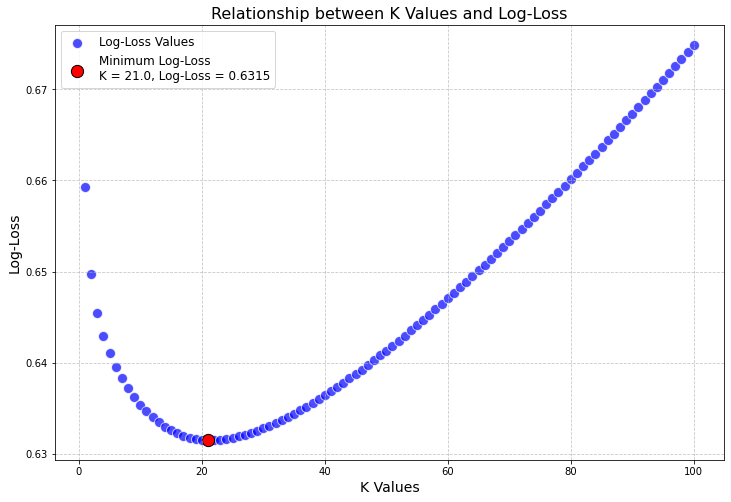

Minimum Log-Loss: 0.6315
Corresponding K: 21.0


In [21]:
# Extract values for plotting
K_values = results_df['K']
logloss = results_df['logloss']

# Create a 2D plot with improved visualization
plt.figure(figsize=(12, 8))
plt.scatter(K_values, logloss, c='blue', alpha=0.7, edgecolors='white', s=100, label='Log-Loss Values')
plt.xlabel('K Values', fontsize=14)
plt.ylabel('Log-Loss', fontsize=14)
plt.title('Relationship between K Values and Log-Loss', fontsize=16)

# Highlight the point with the minimum log-loss
min_logloss_row = results_df.loc[results_df['logloss'].idxmin()]
min_K = min_logloss_row['K']
min_logloss = min_logloss_row['logloss']

plt.scatter(min_K, min_logloss, color='red', s=150, edgecolors='black', label=f'Minimum Log-Loss\nK = {min_K}, Log-Loss = {min_logloss:.4f}')
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Print the corresponding K value
print(f'Minimum Log-Loss: {min_logloss:.4f}')
print(f'Corresponding K: {min_K}')
## Relationship between K Values and Log-Loss

## Split Dataset:

In [22]:
all_matches_k['Date'] = pd.to_datetime(all_matches_k['Date'], format='%Y-%m-%d')
split_time = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
all_matches_k_train = all_matches_k[all_matches_k['Date'] < split_time]
all_matches_k_validation = all_matches_k[all_matches_k['Date'] >= split_time]

## Evaluate Model Performance:

In [23]:
print("\033[1mOptimised K - Metrics\033[0m")
accuracy_k, calibration_k, log_loss_k = evaluate_model(all_matches_k_validation)
print(f"Accuracy: {accuracy_k:.4f}")
print(f"Calibration: {calibration_k:.4f}")
print(f"Log Loss: {log_loss_k:.4f}")

Optimised K - Metrics
Accuracy: 0.6347
Calibration: 1.0279
Log Loss: 0.6315


In [24]:
# Create a DataFrame with the selected metrics
metric_comparison = pd.DataFrame({
    'Model': ['K_Constant_25', 'K_Constant_Optimised'],
    'Accuracy': [results_df.iloc[24][2], accuracy_k],
    'Log_Loss': [results_df.iloc[24][1], log_loss_k],
    'Calibration': [results_df.iloc[24][3], calibration_k]
})

# Print the DataFrame
metric_comparison

,Model,Accuracy,Log_Loss,Calibration
0,K_Constant_25,0.635495,0.631738,1.035578
1,K_Constant_Optimised,0.634700,0.631496,1.027850


## Filtering Top 50 and Top 100 Ranking players from the dataset:

In [25]:
# Load your dataset
df = all_matches_k_validation

In [26]:
# Define function to filter dataset for top N players
def filter_top_players(df, top_n):
    df_top = df[(df['WRank'] <= top_n) | (df['LRank'] <= top_n)]
    return df_top

In [27]:
# Filter the dataset for top 50 and top 100 players
df_top_50 = filter_top_players(df, 50)
df_top_100 = filter_top_players(df, 100)

## Metrics - Top 50 & Top 100:

In [28]:
print("\033[1mMetrics - Top 50\033[0m")
accuracy_50, calibration_50, log_loss_50 = evaluate_model(df_top_50)
print(f"Accuracy: {accuracy_50:.4f}")
print(f"Calibration: {calibration_50:.4f}")
print(f"Log Loss: {log_loss_50:.4f}")

Metrics - Top 50
Accuracy: 0.6591
Calibration: 1.0522
Log Loss: 0.6127


In [29]:
print("\033[1mMetrics - Top 100\033[0m")
accuracy_100, calibration_100, log_loss_100 = evaluate_model(df_top_100)
print(f"Accuracy: {accuracy_100:.4f}")
print(f"Calibration: {calibration_100:.4f}")
print(f"Log Loss: {log_loss_100:.4f}")

Metrics - Top 100
Accuracy: 0.6372
Calibration: 1.0358
Log Loss: 0.6303


In [30]:
# Create a DataFrame to store the validation statistics
validation_stats = pd.DataFrame({
    'Model': [
        'K_Constant_Optimised', 'K_Constant_Optimised Top 50', 'K_Constant_Optimised Top 100'
    ],
    'Accuracy': [
        accuracy_k, accuracy_50, accuracy_100
    ],
    'Log_Loss': [
        log_loss_k, log_loss_50, log_loss_100
    ],
    'Calibration': [
        calibration_k, calibration_50, calibration_100
    ]
})

# Print the validation statistics DataFrame
validation_stats

,Model,Accuracy,Log_Loss,Calibration
0,K_Constant_Optimised,0.634700,0.631496,1.027850
1,K_Constant_Optimised Top 50,0.659117,0.612721,1.052163
2,K_Constant_Optimised Top 100,0.637157,0.630283,1.035779
